In [1]:
%matplotlib inline

from IPython.display import clear_output

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions import Categorical, Bernoulli
import torch.optim as optim
from torch.autograd import Variable

import gym

from itertools import count
import numpy as np

In [2]:
class ActorNet(nn.Module):
    def __init__(self, state_size: int, action_size: int):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 36)
        #self.fc3 = nn.Linear(36, action_size)
        self.fc3 = nn.Linear(36, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        #prob = F.softmax(self.fc3(x), dim=-1)
        #policy = Categorical(prob)
        prob = torch.sigmoid(self.fc3(x))
        policy = Bernoulli(prob)        
        return policy
    
class CriticNet(nn.Module):
    def __init__(self, state_size: int):
        super(CriticNet, self).__init__()
        #self.state_size = state_size
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

In [3]:
def calc_discount_reward(reward_buff, gamma=0.99, normalize=True, done_flag=True):
    prev_dr = 0
    for ii in reversed(range(len(reward_buff))):
        if done_flag and reward_buff[ii] == 0:
            prev_dr = 0            
        else:
            reward_buff[ii] += prev_dr * gamma
            prev_dr = reward_buff[ii]
    
    if normalize:
        mean, std = np.mean(reward_buff), np.std(reward_buff)
        for ii in range(len(reward_buff)):
            reward_buff[ii] = (reward_buff[ii] - mean) / std

Episode:1999


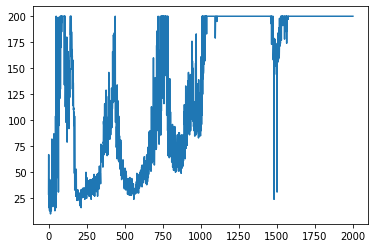

Final results


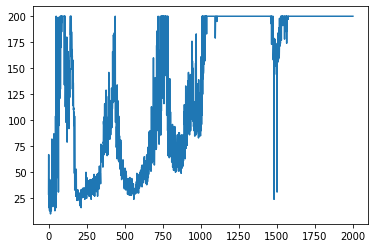

In [4]:
num_episodes = 2000
durations_list = []
render_flag = False
lr = 3e-2
num_batch = 5

def init_buff():
    global state_buff, action_buff, reward_buff
    state_buff = []
    action_buff = []
    reward_buff = []
    
def run(env):
    actor = ActorNet(env.observation_space.shape[0], env.action_space.n)    
    critic = CriticNet(env.observation_space.shape[0])
    optimizer_actor = optim.Adam(actor.parameters(), lr=lr)
    
    init_buff()
    for ep in range(num_episodes):
        state_numpy = env.reset()
        for t in count():
            state_torch = torch.FloatTensor(state_numpy)
            policy, value = actor(state_torch), critic(state_torch)
            action_torch = policy.sample()
            action_int = action_torch.numpy().astype(int)[0]
            next_state_numpy, reward, done, _ = env.step(action_int)
            if render_flag:
                env.render()            
            if done:
                reward = 0
                
            state_buff.append(state_torch)
            action_buff.append(action_torch)
            reward_buff.append(reward)
            
            if done:
                durations_list.append(t+1)
                break
            state_numpy = next_state_numpy
            
        if ep % num_batch == num_batch - 1:
            calc_discount_reward(reward_buff)
            optimizer_actor.zero_grad()
            for state_torch, action_torch, reward in zip(state_buff, action_buff, reward_buff):
                policy = actor(Variable(state_torch))
                loss = -policy.log_prob(Variable(action_torch)) * reward  
                loss.backward()
            optimizer_actor.step()        
            init_buff()
        
        if ep % 100 == 99:
            clear_output()
            print(f'Episode:{ep}')
            plt.plot(durations_list)
            plt.show()
            
    print('Final results')
    plt.plot(durations_list)
    plt.show()    

env = gym.make('CartPole-v0')
run(env)
env.close()